In [ ]:
# default_exp fasta

# FASTA

> Functions related to generating spectra from FASTA files

This notebook contains all functions related to creating spectra from FASTA files. In brief, what we are doing is the following:

1. Read a FASTA file and digest the proteins to generate peptides
2. For each peptide, calculate a theoretical spectrum and precursor mass
3. Save spectra

Currently, `numba` has only limited string support. A lot of the functions are therefore Python-native.

In [ ]:
#hide
from nbdev.showdoc import *

## Cleaving

For cleaving, we use regular expressions to find potential cleavages sites and write the wrapper `cleave_sequence` to use it.

In [ ]:
#export
from alphapept import constants
import re

def get_missed_cleavages(sequences, n_missed_cleavages):
    """
    Combine cleaved sequences to get sequences with missed cleavages
    """
    missed = []
    for k in range(len(sequences)-n_missed_cleavages):
        missed.append(''.join(sequences[k-1:k+n_missed_cleavages]))

    return missed


def cleave_sequence(
    sequence="",
    num_missed_cleavages=0,
    protease="trypsin",
    min_length=6,
    max_length=65,
    **kwargs
):
    """
    Cleave a sequence with a given protease. Filters to have a minimum and maximum length.
    """

    proteases = constants.protease_dict
    pattern = proteases[protease]

    p = re.compile(pattern)

    cutpos = [m.start()+1 for m in p.finditer(sequence)]
    cutpos.insert(0,0)
    cutpos.append(len(sequence))

    base_sequences = [sequence[cutpos[i]:cutpos[i+1]] for i in range(len(cutpos)-1)]

    sequences = base_sequences.copy()

    for i in range(1, num_missed_cleavages+1):
        sequences.extend(get_missed_cleavages(base_sequences, i))

    sequences = [_ for _ in sequences if len(_)>=min_length and len(_)<=max_length]

    return sequences

In [ ]:
protease = "trypsin"
num_missed_cleavages = 0
min_length, max_length = 6, 65

cleave_sequence('ABCDEFGHIJKLMNOPQRST', num_missed_cleavages, protease, min_length, max_length)

['ABCDEFGHIJK', 'LMNOPQR']

In [ ]:
#hide
def test_cleave_sequence():
    
    protease = "trypsin"
    min_length, max_length = 6, 65

    assert set(cleave_sequence('ABCDEFGHIJKLMNOPQRST', 0, protease, min_length, max_length)) == set(['ABCDEFGHIJK', 'LMNOPQR'])
    assert set(cleave_sequence('ABCDEFGHIJKLMNOPQRST', 1, protease, min_length, max_length)) == set(['ABCDEFGHIJK', 'LMNOPQR', 'ABCDEFGHIJKLMNOPQR'])

test_cleave_sequence()

## Counting missed and internal cleavages
The following are helper functions to retrieve the number of missed cleavages and internal cleavage sites for each sequence.

In [ ]:
#export
import re
from alphapept import constants

def count_missed_cleavages(sequence="", protease="trypsin", **kwargs):
    """
    Counts the number of missed cleavages for a given sequence and protease
    """
    proteases = constants.protease_dict
    protease = proteases[protease]
    p = re.compile(protease)
    n_missed = len(p.findall(sequence))
    return n_missed

def count_internal_cleavages(sequence="", protease="trypsin", **kwargs):
    """
    Counts the number of internal cleavage sites for a given sequence and protease
    """
    proteases = constants.protease_dict
    protease = proteases[protease]
    match = re.search(protease,sequence[-1]+'_')
    if match:
        n_internal = 0
    else:
        n_internal = 1
    return n_internal

In [ ]:
protease = "trypsin"
print(count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

protease = "trypsin"
print(count_internal_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

2
1


In [ ]:
#hide
def test_get_missed_cleavages():  
    assert count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', 'trypsin') == 2
    assert count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', 'clostripain') == 1
    
test_get_missed_cleavages()

def test_get_internal_cleavages():
    assert count_internal_cleavages('ABCDEFGHIJKLMNOPQRST', 'trypsin') == 1
    assert count_internal_cleavages('ABCDEFGHIJKLMNOPQRSTK', 'trypsin') == 0

test_get_internal_cleavages()

## Parsing

Peptides are composed out of amino acids that are written in capital letters - `PEPTIDE`. to distinguish modifications, they are written in lowercase such as `PEPTIoxDE` and can be of arbitrary length. For a modified amino acid, the modification precedes the letter of the amino acid. Decoys are indicated with an underscore. Therfore, the `parse` function splits after `_`. When parsing, the peptide string is converted into a numba-compatible list, like so: `PEPoxTIDE` -> `[P, E, P, oxT, I, D, E]`. This allows that we can use the `mass_dict` from `alphapept.constants` to directly determine the masses for the corresponding amino acids.

In [ ]:
#export
from numba import njit
from numba.typed import List

@njit
def parse(peptide):
    """
    Parser to parse peptide strings
    """
    if "_" in peptide:
        peptide = peptide.split("_")[0]
    parsed = List()
    string = ""

    for i in peptide:
        string += i
        if i.isupper():
            parsed.append(string)
            string = ""

    return parsed

def list_to_numba(a_list):
    numba_list = List()

    for element in a_list:
        numba_list.append(element)

    return numba_list

In [ ]:
print(parse('PEPTIDE'))
print(parse('PEPoxTIDE'))

[P, E, P, T, I, D, E]
[P, E, P, oxT, I, D, E]


In [ ]:
#hide
def test_parse():
    peptide = "PEPTIDE"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "T", "I", "D", "E"])
    peptide = "PEPoxTIDE"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "oxT", "I", "D", "E"])
    peptide = "PEPTIDE_decoy"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "T", "I", "D", "E"])
    
test_parse()

## Decoy

The decoy strategy employed is a pseudo-reversal of the peptide sequence, keeping only the terminal amino-acid and reversing the rest. Additionally, we can call the functions `swap_KR` and and `swap_AL` that will swap the respective AAs. The function `swap_KR` will only swap terminal AAs. The swapping functions only work if the AA is not modified.

In [ ]:
#export
@njit
def get_decoy_sequence(peptide, pseudo_reverse=False, AL_swap=False, KR_swap = False):
    """
    Reverses a sequence and adds the '_decoy' tag.

    """
    pep = parse(peptide)
    if pseudo_reverse:
        rev_pep = pep[:-1][::-1]
        rev_pep.append(pep[-1])
    else:
        rev_pep = pep[::-1]

    if AL_swap:
        rev_pep = swap_AL(rev_pep)

    if KR_swap:
        rev_pep = swap_KR(rev_pep)

    rev_pep = "".join(rev_pep)

    return rev_pep


@njit
def swap_KR(peptide):
    """
    Swaps a terminal K or R. Note: Only if AA is not modified.
    """
    if peptide[-1] == 'K':
        peptide[-1] = 'R'
    elif peptide[-1] == 'R':
        peptide[-1] = 'K'

    return peptide


@njit
def swap_AL(peptide):
    """
    Swaps a A with L. Note: Only if AA is not modified.
    """
    i = 0
    while i < len(range(len(peptide) - 1)):
        if peptide[i] == "A":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "A"
            i += 1
        elif peptide[i] == "L":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "L"
            i += 1
        i += 1

    #aa_table = "GAVLIFMPWSCTYHKRQEND"
    #DiaNN_table  = "LLLVVLLLLTSSSSLLNDQE"

    #idx = aa_table.find(peptide[-2])
    #peptide[-2] = decoy_table[idx]

    return peptide

def get_decoys(peptide_list, pseudo_reverse=False, AL_swap=False, KR_swap = False, **kwargs):
    """
    Wrapper to get decoys for lists of peptides
    """
    decoys = []
    decoys.extend([get_decoy_sequence(peptide, pseudo_reverse, AL_swap, KR_swap) for peptide in peptide_list])
    return decoys

def add_decoy_tag(peptides):
    """
    Adds a _decoy tag to a list of peptides
    """
    return [peptide + "_decoy" for peptide in peptides]

In [ ]:
print(swap_AL(parse('KKKALKKK')))
print(swap_KR(parse('AAAKRAAA')))

[K, K, K, L, A, K, K, K]
[A, A, A, K, R, A, A, A]


In [ ]:
print(get_decoy_sequence('PEPTIDE'))

EDITPEP


In [ ]:
print(get_decoys(['ABC','DEF','GHI']))

['CBA', 'FED', 'IHG']


In [ ]:
#hide

def test_swap_AL():
    assert swap_AL(parse("ABCDEF")) == parse("BACDEF")
    assert swap_AL(parse("GHIKLM")) == parse("GHIKML")
    assert swap_AL(parse("FEDCBA")) == parse("FEDCBA")
    assert swap_AL(parse("GHIKL")) == parse("GHIKL")
    assert swap_AL(parse("ABCDEFGHIKLM")) == parse("BACDEFGHIKML")
    assert swap_AL(parse("BBAcCD")) == parse("BBcCAD")
    assert swap_AL(parse("FEDCBA")) == parse("FEDCBA")

test_swap_AL()

def test_swapKR():
    assert swap_KR(parse("ABCDEK")) == parse("ABCDER")
    assert swap_KR(parse("ABCDER")) == parse("ABCDEK")
    assert swap_KR(parse("ABCDEF")) == parse("ABCDEF")
    assert swap_KR(parse("KABCDEF")) == parse("KABCDEF")
    assert swap_KR(parse("KABCRDEF")) == parse("KABCRDEF")
    assert swap_KR(parse("KABCKDEF")) == parse("KABCKDEF")

test_swapKR()
    
def test_get_decoy_sequence():
    peptide = "PEPTIDER"
    assert get_decoy_sequence(peptide, pseudo_reverse=True) == "EDITPEPR"
    assert get_decoy_sequence(peptide) == "REDITPEP"
    assert get_decoy_sequence(peptide, KR_swap=True, pseudo_reverse=True) == "EDITPEPK"
    
test_get_decoy_sequence()

## Modifications

To add modifications to the peptides, we distinguish fixed and variable modifications. Additionally, we make a distinction between whether the modification is only terminal or not. 

### Fixed Modifications
Fixed modifications are implemented by passing a list with modified AAs that should be replaced. As a AA is only one letter, the remainder is the modification. 

In [ ]:
#export
def add_fixed_mods(seqs, mods_fixed, **kwargs):
    """
    Adds fixed modifications to sequences.
    """
    if not mods_fixed:
        return seqs
    else:
        for mod_aa in mods_fixed:
            seqs = [seq.replace(mod_aa[-1], mod_aa) for seq in seqs]
        return seqs

In [ ]:
mods_fixed = ['cC','bB']
peptide_list = ['ABCDEF']

add_fixed_mods(peptide_list, mods_fixed)

['AbBcCDEF']

In [ ]:
#hide
def test_add_fixed_mods():
    mods_fixed = ['cC']
    peptide_list = ['ABCDEF']

    peptides_new = add_fixed_mods(peptide_list, [])
    assert peptides_new == peptide_list
    
    peptides_new = add_fixed_mods(peptide_list, mods_fixed)
    assert peptides_new == ['ABcCDEF']
    
test_add_fixed_mods()

### Variable Modifications

To employ variable modifications, we use the function `get_mod_pos` that returns a list of tuples with all possible modifications when giving a dicitionary with variable modifications.  

In [ ]:
from alphapept.fasta import parse

In [ ]:
#export
def add_variable_mod(peps, mods_variable_dict):
    peptides = []
    for pep in peps:
        for mod in mods_variable_dict:
            for i in range(len(pep)):
                c = pep[i]
                if c in mods_variable_dict:
                    peptides.append(pep[:i]+[mods_variable_dict[c]]+pep[i+1:])
                
    return peptides


def get_isoforms(mods_variable_dict, peptide, max_isoforms):
    """
    Function to generate isoforms for a given peptide - returns a list of isoforms.
    The original sequence is included in the list
    """
    pep = list(parse(peptide))

    peptides = [pep]
    new_peps = peptides
    while len(peptides) < max_isoforms:
        new_peps = add_variable_mod(new_peps, mods_variable_dict)
        if len(new_peps) == 0:
            break
        peptides.extend(new_peps)

    peptides = [''.join(_) for _ in peptides]

    return peptides

In [ ]:
mods_variable_dict = {'M':'oxM'}
peptide = 'AMAMA'
max_isoforms = 1024
get_isoforms(mods_variable_dict, peptide, max_isoforms)

['AMAMA', 'AoxMAMA', 'AMAoxMA', 'AoxMAoxMA', 'AoxMAoxMA']

Lastly, we define the wrapper `add_variable_mods` so that the functions can be called for lists of peptides and a list of variable modifications.

In [ ]:
#export 
from itertools import chain

def add_variable_mods(peptide_list, mods_variable, max_isoforms, **kwargs):
    #the peptide_list originates from one peptide already -> limit isoforms here
    
    max_ = max_isoforms - len(peptide_list) + 1
    
    if max_ < 0:
        max_ = 0
    
    if not mods_variable:
        return peptide_list
    else:
        mods_variable_r = {}
        for _ in mods_variable:
            mods_variable_r[_[-1]] = _

        peptide_list = [get_isoforms(mods_variable_r, peptide, max_) for peptide in peptide_list]
        return list(chain.from_iterable(peptide_list))

In [ ]:
peptide_list = ['AMA', 'AAC']
mods_variable = ['oxM','amC']
max_isoforms = 1024

add_variable_mods(peptide_list, mods_variable, max_isoforms)

['AMA', 'AoxMA', 'AoxMA', 'AAC', 'AAamC', 'AAamC']

In [ ]:
#hide
def test_add_variable_mods():
    mods_variable = ['oxM']
    peptide = ['AMAMA']

    peptides_new = add_variable_mods(peptide, [], 1024)
    assert peptides_new == peptide

    peptides_new = add_variable_mods(peptide, mods_variable, 1024)

    assert set(['AMAMA', 'AMAoxMA', 'AoxMAMA', 'AoxMAoxMA']) == set(peptides_new)

    # Check if number of isoforms is correct
    peptides_new = add_variable_mods(peptide, mods_variable, 3)
    assert len(peptides_new) == 3
    
test_add_variable_mods()

### Terminal Modifications - Fixed

To handle terminal modifications, we use the following convention:

* `<` for the left side (N-terminal)
* `>` for the right side (C-Terminal)

Additionally, if we want to have a terminal modification on any AA we indicate this `^`.

In [ ]:
#export
def add_fixed_mod_terminal(peptides, mod):
    """
    Adds fixed terminal modifications
    """
    # < for left side (N-Term), > for right side (C-Term)
    if "<^" in mod: #Any n-term, e.g. a<^
        peptides = [mod[:-2] + peptide for peptide in peptides]
    elif ">^" in mod: #Any c-term, e.g. a>^
        peptides = [peptide[:-1] + mod[:-2] + peptide[-1] for peptide in peptides]
    elif "<" in mod: #only if specific AA, e.g. ox<C
        peptides = [peptide[0].replace(mod[-1], mod[:-2]+mod[-1]) + peptide[1:] for peptide in peptides]
    elif ">" in mod:
        peptides = [peptide[:-1] + peptide[-1].replace(mod[-1], mod[:-2]+mod[-1]) for peptide in peptides]
    else:
        # This should not happen
        raise ("Invalid fixed terminal modification {}.".format(key))
    return peptides

def add_fixed_mods_terminal(peptides, mods_fixed_terminal, **kwargs):
    """
    Wrapper to add fixed mods on sequences and lists of mods
    """
    if mods_fixed_terminal == []:
        return peptides
    else:
        # < for left side (N-Term), > for right side (C-Term)
        for key in mods_fixed_terminal:
            peptides = add_fixed_mod_terminal(peptides, key)
        return peptides

In [ ]:
peptide = ['AMAMA']

print('Any n-term modified with x (x<^):', add_fixed_mods_terminal(peptide, ['x<^']))
print('Any c-term modified with x (x>^):', add_fixed_mods_terminal(peptide, ['x>^']))
print('Only A on n-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x<A']))
print('Only A on c-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x>A']))

Any n-term modified with x (x<^): ['xAMAMA']
Any c-term modified with x (x>^): ['AMAMxA']
Only A on n-term modified with x (x<A): ['xAMAMA']
Only A on c-term modified with x (x<A): ['AMAMxA']


In [ ]:
#hide

def test_add_fixed_mods_terminal():
    peptide = ['AMAMA']

    peptides_new = add_fixed_mods_terminal(peptide, [])
    assert peptides_new == peptide

    #Any N-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x<^'])
    assert peptides_new == ['xAMAMA']

    #Any C-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x>^'])
    assert peptides_new == ['AMAMxA']

    #Selected N-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x<A'])
    assert peptides_new == ['xAMAMA']

    peptides_new = add_fixed_mods_terminal(peptide, ['x<C'])
    assert peptides_new == peptide

    #Selected C-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x>A'])
    assert peptides_new == ['AMAMxA']

    peptides_new = add_fixed_mods_terminal(peptide, ['x>C'])
    assert peptides_new == peptide
    
test_add_fixed_mods_terminal()

### Terminal Modifications - Variable

Lastly, to handle terminal variable modifications we use the function `add_variable_mods_terminal`. As the modifcation can only be at the terminal end this function only adds a peptide where the terminal end is modified.

In [ ]:
#export
def add_variable_mods_terminal(peptides, mods_variable_terminal, **kwargs):
    "Function to add variable terminal modifications"
    if not mods_variable_terminal:
        return peptides
    else:
        new_peptides_n = peptides.copy()

        for key in mods_variable_terminal:
            if "<" in key:
                # Only allow one variable mod on one end
                new_peptides_n.extend(
                    add_fixed_mod_terminal(peptides, key)
                )
        new_peptides_n = get_unique_peptides(new_peptides_n)
        # N complete, let's go for c-terminal
        new_peptides_c = new_peptides_n
        for key in mods_variable_terminal:
            if ">" in key:
                # Only allow one variable mod on one end
                new_peptides_c.extend(
                    add_fixed_mod_terminal(new_peptides_n, key)
                )

        return get_unique_peptides(new_peptides_c)

def get_unique_peptides(peptides):
    return list(set(peptides))

In [ ]:
peptide_list = ['AMAMA']
add_variable_mods_terminal(peptide_list, ['x<^'])

['xAMAMA', 'AMAMA']

In [ ]:
#hide
def test_add_variable_mods_terminal():
    peptide_list = ['AMAMA']

    peptides_new = add_variable_mods_terminal(peptide_list, [])
    assert peptides_new == peptide

    #Any N-term
    peptides_new = add_variable_mods_terminal(peptide_list, ['x<^'])
    assert set(peptides_new) == set(['xAMAMA', 'AMAMA'])
    
test_add_variable_mods_terminal()

### Generating Peptides

Lastly we put all the functions into a wrapper `generate_peptides`. It will accept a peptide and a dictionary with settings so that we can get all modified peptides

In [ ]:
#export
def generate_peptides(peptide, **kwargs):
    """
    Wrapper to get modified peptides from a peptide
    """
    mod_peptide = add_fixed_mods_terminal([peptide], kwargs['mods_fixed_terminal_prot'])
    mod_peptide = add_variable_mods_terminal(mod_peptide, kwargs['mods_variable_terminal_prot'])

    peptides = []
    [peptides.extend(cleave_sequence(_, **kwargs)) for _ in mod_peptide]
    
    all_peptides = []
    for peptide in peptides:
        #Regular peptides
        mod_peptides = add_fixed_mods([peptide], **kwargs)
        mod_peptides = add_fixed_mods_terminal(mod_peptides, **kwargs)
        mod_peptides = add_variable_mods_terminal(mod_peptides, **kwargs)
        mod_peptides = add_variable_mods(mod_peptides, **kwargs)
        
        all_peptides.extend(mod_peptides)

        #Decoys:
        decoy_peptides = get_decoys([peptide], **kwargs)

        mod_peptides_decoy = add_fixed_mods(decoy_peptides, **kwargs)
        mod_peptides_decoy = add_fixed_mods_terminal(mod_peptides_decoy, **kwargs)
        mod_peptides_decoy = add_variable_mods_terminal(mod_peptides_decoy, **kwargs)
        mod_peptides_decoy = add_variable_mods(mod_peptides_decoy, **kwargs)

        mod_peptides_decoy = add_decoy_tag(mod_peptides_decoy)

        
        all_peptides.extend(mod_peptides_decoy)

    return all_peptides

In [ ]:
kwargs = {}

kwargs["protease"] = "trypsin"
kwargs["num_missed_cleavages"] = 2
kwargs["min_length"] = 6
kwargs["max_length"] = 27
kwargs["mods_variable"] = ["oxM"]
kwargs["mods_variable_terminal"] = []
kwargs["mods_fixed"] = ["cC"]
kwargs["mods_fixed_terminal"] = []
kwargs["mods_fixed_terminal_prot"] = []
kwargs["mods_variable_terminal_prot"]  = []
kwargs["max_isoforms"] = 1024

generate_peptides('PEPTIDEM', **kwargs)

['PEPTIDEM', 'PEPTIDEoxM', 'MEDITPEP_decoy', 'oxMEDITPEP_decoy']

In [ ]:
cleave_sequence('PEPTIDEM')

['PEPTIDEM']

In [ ]:
#hide
def test_generate_peptides():
    kwargs = {}

    kwargs["protease"] = "trypsin"
    kwargs["num_missed_cleavages"] = 2
    kwargs["min_length"] = 6
    kwargs["max_length"] = 27
    kwargs["mods_variable"] = ["oxM"]
    kwargs["mods_variable_terminal"] = []
    kwargs["mods_fixed"] = ["cC"]
    kwargs["mods_fixed_terminal"] = []
    kwargs["mods_fixed_terminal_prot"] = []
    kwargs["mods_variable_terminal_prot"]  = []
    kwargs["max_isoforms"] = 1024
    kwargs['pseudo_reverse'] = True

    peps = generate_peptides('PEPTIDEM', **kwargs)
    assert set(peps) == set(['PEPTIDEM', 'PEPTIDEoxM', 'EDITPEPM_decoy', 'EDITPEPoxM_decoy'])
    
test_generate_peptides()

## Mass Calculations

Using the `mass_dict` from `constants` and being able to parse sequences with `parse` one can simply look up the masses for each modified or unmodified amino acid and add everything up.

### Precursor

To calculate the mass of the neutral precursor we start with the mass of an $H_2O$ and add the masses of all amino acids of the sequence.

In [ ]:
#export
from numba import njit
from numba.typed import List
import numpy as np

@njit
def get_precmass(parsed_pep, mass_dict):
    """
    Calculate the mass of the neutral precursor
    """
    tmass = mass_dict["H2O"]
    for _ in parsed_pep:
        tmass += mass_dict[_]

    return tmass

In [ ]:
get_precmass(parse('PEPTIDE'), constants.mass_dict)

799.3599642034599

In [ ]:
#hide
def test_get_precmass():
    
    precmass = get_precmass(parse('PEPTIDE'), constants.mass_dict)
    
    assert np.allclose(precmass, 799.3599642034599)
    
test_get_precmass()

### Fragments

Likewise, we can calculate the masses of the fragment ions. We employ two functions: `get_fragmass` and `get_frag_dict`. 

`get_fragmass` is a fast, `numba`-compatible function that calculates the fragmasses and returns an array indicating wheter the iontype was `b` or `y`. 

`get_frag_dict` instead is not `numba`-compatible and hence a bit slower. It returns a dictionary with the respective ion and can be used for plotting theoretical spectra.

In [ ]:
#export

@njit
def get_fragmass(parsed_pep, mass_dict):
    """
    Calculate the masses of the fragment ions
    """
    n_frags = (len(parsed_pep) - 1) * 2

    frag_masses = np.zeros(n_frags, dtype=np.float64)
    frag_type = np.zeros(n_frags, dtype=np.int8)

    # b-ions > 0
    n_frag = 0
    
    frag_m = mass_dict["Proton"]
    for idx, _ in enumerate(parsed_pep[:-1]):
        frag_m += mass_dict[_]
        frag_masses[n_frag] = frag_m
        frag_type[n_frag] = (idx+1)
        n_frag += 1
        
    # y-ions < 0
    frag_m = mass_dict["Proton"] + mass_dict["H2O"]
    for idx, _ in enumerate(parsed_pep[::-1][:-1]):
        frag_m += mass_dict[_]
        frag_masses[n_frag] = frag_m
        frag_type[n_frag] = -(idx+1)
        n_frag += 1

    return frag_masses, frag_type

In [ ]:
get_fragmass(parse('PEPTIDE'), constants.mass_dict)

(array([ 98.06004033, 227.10263343, 324.15539729, 425.20307579,
        538.28713979, 653.31408289, 148.06043425, 263.08737735,
        376.17144135, 477.21911985, 574.27188371, 703.31447681]),
 array([ 1,  2,  3,  4,  5,  6, -1, -2, -3, -4, -5, -6], dtype=int8))

In [ ]:
#hide
def test_get_fragmass():
    
    frag_masses, frag_type = get_fragmass(parse('PEPTIDE'), constants.mass_dict)
    
    ref_masses = np.array([ 98.06004033, 227.10263343, 324.15539729, 425.20307579,
        538.28713979, 653.31408289, 148.06043425, 263.08737735,
        376.17144135, 477.21911985, 574.27188371, 703.31447681])
    
    assert np.allclose(frag_masses, ref_masses)
                          
test_get_fragmass()

In [ ]:
#export
def get_frag_dict(parsed_pep, mass_dict):
    
    frag_dict = {}
    frag_masses, frag_type = get_fragmass(parsed_pep, constants.mass_dict)
    
    for idx, _ in enumerate(frag_masses):
        
        cnt = frag_type[idx]
        if cnt > 0:
            identifier = 'b'
        else:
            identifier = 'y'
            cnt = -cnt
        frag_dict[identifier+str(cnt)] = _
           
    return frag_dict

In [ ]:
get_frag_dict(parse('PEPTIDE'), constants.mass_dict)

{'b1': 98.06004032687,
 'b2': 227.10263342686997,
 'b3': 324.15539728686997,
 'b4': 425.20307578687,
 'b5': 538.28713978687,
 'b6': 653.31408288687,
 'y1': 148.06043425033,
 'y2': 263.08737735033,
 'y3': 376.1714413503299,
 'y4': 477.21911985032995,
 'y5': 574.2718837103299,
 'y6': 703.3144768103299}

In [ ]:
#hide
def test_get_frag_dict():
    
    refdict = {'b1': 98.06004032687,
 'b2': 227.10263342686997,
 'b3': 324.15539728686997,
 'y1': 120.06551965033,
 'y2': 217.11828351033,
 'y3': 346.16087661033}
    
    newdict = get_frag_dict(parse('PEPT'), constants.mass_dict)
    
    for key in newdict.keys():
        
        assert np.allclose(refdict[key], newdict[key])
        
test_get_frag_dict()

This allows us also to generate the theorteical isotopes for a fragment:

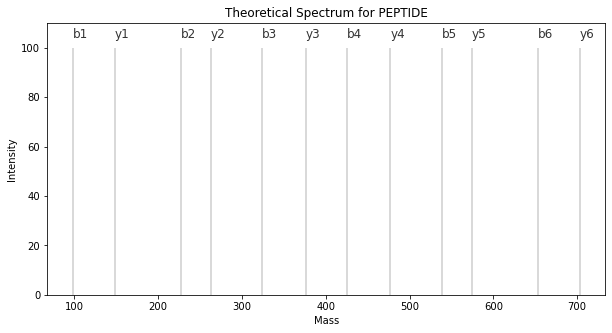

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
peptide = 'PEPTIDE'

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)

db_frag = list(frag_dict.values())
db_int = [100 for _ in db_frag]

plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.ylim([0,110])
plt.show()

### Spectra

The function `get_spectrum` returns a tuple with the following content:

* precursor mass
* peptide sequence
* fragmasses
* fragtypes

Likewise, `get_spectra` returns a list of tuples. We employ a list of tuples here as this way we can sort them easily by precursor mass.

In [ ]:
#export
@njit
def get_spectrum(peptide, mass_dict):
    parsed_peptide = parse(peptide)

    fragmasses, fragtypes = get_fragmass(parsed_peptide, mass_dict)
    sortindex = np.argsort(fragmasses)
    fragmasses = fragmasses[sortindex]
    fragtypes = fragtypes[sortindex]

    precmass = get_precmass(parsed_peptide, mass_dict)

    return (precmass, peptide, fragmasses, fragtypes)

@njit
def get_spectra(peptides, mass_dict):
    spectra = List()

    for i in range(len(peptides)):
        spectra.append(get_spectrum(peptides[i], mass_dict))

    return spectra

In [ ]:
print(get_spectra(List(['PEPTIDE']), constants.mass_dict))

[(799.3599642034599, 'PEPTIDE', array([ 98.06004033, 148.06043425, 227.10263343, 263.08737735,
       324.15539729, 376.17144135, 425.20307579, 477.21911985,
       538.28713979, 574.27188371, 653.31408289, 703.31447681]), array([ 1, -1,  2, -2,  3, -3,  4, -4,  5, -5,  6, -6], dtype=int8))]


In [ ]:
#hide
def test_get_spectra():
    
    spectra = get_spectra(List(['PEPTIDE']), constants.mass_dict)
    
    precmass, peptide, frags, fragtypes = spectra[0]
    
    assert np.allclose(precmass, 799.3599642034599)
    
    assert peptide == 'PEPTIDE'
    
    assert np.allclose(frags, np.array([ 98.06004033, 148.06043425, 227.10263343, 263.08737735,
       324.15539729, 376.17144135, 425.20307579, 477.21911985,
       538.28713979, 574.27188371, 653.31408289, 703.31447681]))

test_get_spectra()

## Reading FASTA

To read FASTA files we use the `SeqIO` module from the `Biopython` library. This is a generator expression so that we read one FASTA entry after another until the `StopIteration` is reached, which is implemented in `read_fasta_file`. Additionally, we define the funciton `read_fasta_file_entries` that simply counts the number of FASTA entries.

All FASTA entries that contain AAs which are not in the mass_dict can be checked with `check_sequence` and will be ignored.

In [ ]:
#export
from Bio import SeqIO
import os
from glob import glob
import logging

def read_fasta_file(fasta_filename=""):
    """
    Read a FASTA file line by line
    """
    with open(fasta_filename, "rt") as handle:
        iterator = SeqIO.parse(handle, "fasta")
        while iterator:
            try:
                record = next(iterator)
                parts = record.id.split("|")  # pipe char
                if len(parts) > 1:
                    id = parts[1]
                else:
                    id = record.name
                sequence = str(record.seq)
                entry = {
                    "id": id,
                    "name": record.name,
                    "description": record.description,
                    "sequence": sequence,
                }

                yield entry
            except StopIteration:
                break


def read_fasta_file_entries(fasta_filename=""):
    """
    Function to count entries in fasta file
    """
    with open(fasta_filename, "rt") as handle:
        iterator = SeqIO.parse(handle, "fasta")
        count = 0
        while iterator:
            try:
                record = next(iterator)
                count+=1
            except StopIteration:
                break

        return count


def check_sequence(element, AAs):
    """
    Checks wheter a sequence from a FASTA entry contains valid AAs
    """
    if not set(element['sequence']).issubset(AAs):
        unknown = set(element['sequence']) - set(AAs)
        logging.error(f'This FASTA entry contains unknown AAs {unknown} and will be skipped: \n {element}\n')
        return False
    else:
        return True

In [ ]:
#load example fasta file

fasta_path = '../testfiles/test.fasta'

list(read_fasta_file(fasta_path))[0]

{'id': 'A0PJZ0',
 'name': 'sp|A0PJZ0|A20A5_HUMAN',
 'description': 'sp|A0PJZ0|A20A5_HUMAN Putative ankyrin repeat domain-containing protein 20A5 OS=Homo sapiens OX=9606 GN=ANKRD20A5P PE=5 SV=1',
 'sequence': 'MKLFGFRSRRGQTVLGSIDHLYTGSGYRIRYSELQKIHKAAVKGDAAEMERCLARRSGDLDALDKQHRTALHLACASGHVKVVTLLVNRKCQIDIYDKENRTPLIQAVHCQEEACAVILLEHGANPNLKDIYGNTALHYAVYSESTSLAEKLLFHGENIEALDKV'}

## Peptide Dictionary

In order to efficiently store peptides, we rely on the Python dictionary. The idea is to have a dictionary with peptides as keys and indices to proteins as values. This way, one can quickly look up to which protein a peptide belongs to. The function `add_to_pept_dict` uses a regular python dictionary and allows to add peptides and stores indices to the originating proteins as a list. If a peptide is already present in the dictionary, the list is appended. The function returns a list of `added_peptides`, which were not present in the dictionary yet. One can use the function `merge_pept_dicts` to merge multiple peptide dicts.

In [ ]:
#export
def add_to_pept_dict(pept_dict, new_peptides, i):
    """
    Add peptides to the peptide dictionary
    """
    added_peptides = List()
    for peptide in new_peptides:
        if peptide in pept_dict:
            pept_dict[peptide].append(i)
        else:
            pept_dict[peptide] = [i]
            added_peptides.append(peptide)

    return pept_dict, added_peptides

In [ ]:
pept_dict = {}
new_peptides = ['ABC','DEF']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 0)

new_peptides = ['DEF','GHI']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 1)

print(pept_dict)

{'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}


In [ ]:
#hide

def test_add_to_pept_dict():
    pept_dict = {}
    new_peptides = ['ABC','DEF']

    pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 0)

    new_peptides = ['DEF','GHI']

    pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 1)
    
    assert pept_dict == {'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}
    
test_add_to_pept_dict()

In [ ]:
#export

def merge_pept_dicts(list_of_pept_dicts):
    
    if len(list_of_pept_dicts) == 0:
        raise ValueError('Need to pass at least 1 element.')
    
    new_pept_dict = list_of_pept_dicts[0]

    for pept_dict in list_of_pept_dicts[1:]:

        for key in pept_dict.keys():
            if key in new_pept_dict:
                for element in pept_dict[key]:
                    new_pept_dict[key].append(element)
            else:
                new_pept_dict[key] = pept_dict[key]

    return new_pept_dict

In [ ]:
pept_dict_1 = {'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}
pept_dict_2 = {'ABC': [3,4], 'JKL': [5, 6], 'MNO': [7]}

merge_pept_dicts([pept_dict_1, pept_dict_2])

{'ABC': [0, 3, 4], 'DEF': [0, 1], 'GHI': [1], 'JKL': [5, 6], 'MNO': [7]}

In [ ]:
def test_merge_pept_dicts():
    pept_dict_1 = {'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}
    pept_dict_2 = {'ABC': [3,4], 'JKL': [5, 6], 'MNO': [7]}

    assert merge_pept_dicts([pept_dict_1, pept_dict_2]) == {'ABC': [0, 3, 4], 'DEF': [0, 1], 'GHI': [1], 'JKL': [5, 6], 'MNO': [7]}
    
test_merge_pept_dicts()

## Generating a database

To wrap everything up, we employ two functions `generate_database` and `generate_spectra`. The first one reads a FASTA file and generates a list of peptides, as well as the peptide dictionary and an ordered FASTA dictionary to be able to look up the protein indices laster. For the `callback` we first read the whole FASTA file to determine the total number of entries in the FASTA file.  For a typical FASTA file of 30 Mb with 40k entries, this should take less than a second. The progress of the digestion is monitored by processing the FASTA file one by one.
The function `generate_spectra` then calculates precursor masses and fragment ions. Here, we split the total_number of sequences in `1000` steps to be able to track progress with the `callback`.

In [ ]:
#export
from collections import OrderedDict

def generate_fasta_list(fasta_paths, callback = None, **kwargs):
    """
    Function to generate a database from a fasta file
    """
    fasta_list = []

    fasta_dict = OrderedDict()

    fasta_index = 0

    if type(fasta_paths) is str:
        fasta_paths = [fasta_paths]
        n_fastas = 1

    elif type(fasta_paths) is list:
        n_fastas = len(fasta_paths)

    for f_id, fasta_file in enumerate(fasta_paths):
        n_entries = read_fasta_file_entries(fasta_file)

        fasta_generator = read_fasta_file(fasta_file)

        for element in fasta_generator:
            if check_sequence(element, constants.AAs):
                fasta_list.append(element)
                fasta_dict[fasta_index] = element
                fasta_index += 1

    return fasta_list, fasta_dict


def generate_database(mass_dict, fasta_paths, callback = None, **kwargs):
    """
    Function to generate a database from a fasta file
    """
    to_add = List()
    fasta_dict = OrderedDict()
    fasta_index = 0

    pept_dict = {}

    if type(fasta_paths) is str:
        fasta_paths = [fasta_paths]
        n_fastas = 1

    elif type(fasta_paths) is list:
        n_fastas = len(fasta_paths)

    for f_id, fasta_file in enumerate(fasta_paths):
        n_entries = read_fasta_file_entries(fasta_file)

        fasta_generator = read_fasta_file(fasta_file)

        for element in fasta_generator:
            if check_sequence(element, constants.AAs):
                fasta_dict[fasta_index] = element
                mod_peptides = generate_peptides(element["sequence"], **kwargs)
                pept_dict, added_seqs = add_to_pept_dict(pept_dict, mod_peptides, fasta_index)
                if len(added_seqs) > 0:
                    to_add.extend(added_seqs)

            fasta_index += 1

            if callback:
                callback(fasta_index/n_entries/n_fastas+f_id)

    return to_add, pept_dict, fasta_dict


def generate_spectra(to_add, mass_dict, callback = None):
    """
    Function to generate a database from a fasta file
    """

    if len(to_add) > 0:

        if callback: #Chunk the spectra to get a progress_bar
            spectra = []

            stepsize = int(np.ceil(len(to_add)/1000))

            for i in range(0, len(to_add), stepsize):
                sub = to_add[i:i + stepsize]
                spectra.extend(get_spectra(sub, mass_dict))
                callback((i+1)/len(to_add))

        else:
            spectra = get_spectra(to_add, mass_dict)
    else:
        raise ValueError("No spectra to generate.")

    return spectra

## Parallelized version

To speed up spectra generated, one can use the parallelized version. The function `generate_database_parallel` reads an entire FASTA file and splits it into multiple blocks. Each block will be processed, and the generated pept_dicts will be merged.

In [ ]:
#export
from multiprocessing import Pool
from alphapept import constants
mass_dict = constants.mass_dict

def block_idx(len_list, block_size = 1000):
    """
    Create indices for a list of length len_list
    """
    blocks = []
    start = 0
    end = 0

    while end <= len_list:
        end += block_size
        blocks.append((start, end))
        start = end

    return blocks

def blocks(l, n):
    """
    Create blocks from a given list
    """
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

def digest_fasta_block(to_process):
    """
    Digest and create spectra for a whole fasta_block
    """

    fasta_index, fasta_block, settings = to_process

    to_add = List()

    f_index = 0

    pept_dict = {}
    for element in fasta_block:
        sequence = element["sequence"]
        mod_peptides = generate_peptides(sequence, **settings['fasta'])
        pept_dict, added_peptides = add_to_pept_dict(pept_dict, mod_peptides, fasta_index+f_index)

        if len(added_peptides) > 0:
            to_add.extend(added_peptides)
        f_index += 1

    spectra = []
    if len(to_add) > 0:
        for specta_block in blocks(to_add, settings['fasta']['spectra_block']):
            spectra.extend(generate_spectra(specta_block, mass_dict))

    return (spectra, pept_dict)

def generate_database_parallel(settings, callback = None):
    """
    Function to generate a database from a fasta file
    """
    n_processes = settings['general']['n_processes']

    fasta_list, fasta_dict = generate_fasta_list(**settings['fasta'])

    blocks = block_idx(len(fasta_list), settings['fasta']['fasta_block'])

    to_process = [(idx_start, fasta_list[idx_start:idx_end], settings) for idx_start, idx_end in  blocks]

    spectra = []
    pept_dicts = []
    with Pool(n_processes) as p:
        max_ = len(to_process)
        for i, _ in enumerate(p.imap_unordered(digest_fasta_block, to_process)):
            if callback:
                callback((i+1)/max_)
            spectra.extend(_[0])
            pept_dicts.append(_[1])

    spectra = sorted(spectra, key=lambda x: x[1])
    spectra_set = [spectra[idx] for idx in range(len(spectra)-1) if spectra[idx][1] != spectra[idx+1][1]]
    spectra_set.append(spectra[-1])

    pept_dict = merge_pept_dicts(pept_dicts)

    return spectra_set, pept_dict, fasta_dict

### Parallel search on large files

In some cases (i.e., a lot of modifications), it will not be useful to save the database as it will consume too much memory. Here, we use the function `search_parallel` from search. It creates theoretical spectra on the fly and directly searches against them. As we cannot create a pept_dict here, we need to create one from the search results. For this, we group peptides by their FASTA index and generate a lookup dictionary that can be used as a pept_dict.

> Note that we are passing the settings argument here. Search results should be stored in the corresponding path in the hdf file.

In [ ]:
#export
def pept_dict_from_search(settings):
    """
    Generates a peptide dict from a large search
    """

    paths = settings['experiment']['files']

    bases = [os.path.splitext(_)[0]+'.hdf' for _ in paths]

    all_dfs = []
    for _ in bases:
        try:
            df = pd.read_hdf(_, key='peptide_fdr')
        except KeyError:
            df = pd.DataFrame()

        if df > 0:
            all_dfs.append(df)

    df = pd.concat(all_dfs)

    df['fasta_index'] = df['fasta_index'].str.split(',')

    lst_col = 'fasta_index'

    df_ = pd.DataFrame({
          col:np.repeat(df[col].values, df[lst_col].str.len())
          for col in df.columns.drop(lst_col)}
        ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]

    df_['fasta_index'] = df_['fasta_index'].astype('int')
    df_grouped = df_.groupby(['sequence'])['fasta_index'].unique()

    pept_dict = {}
    for keys, vals in zip(df_grouped.index, df_grouped.values):
        pept_dict[keys] = vals.tolist()

    return pept_dict

## Saving

To save the generated spectra, we rely on NumPy's NPZ format. For this, we create a dictionary and save all the generated elements. The container will contain the following elements:

* `precursors`: An array containing the precursor masses
* `seqs`: An array containing the peptide sequences for the precursor masses
* `pept_dict`: A peptide dictionary to look up the peptides and return their FASTA index
* `fasta_dict`: A fasta dictionary to look up the FASTA entry based on a pept_dict index
* `fragmasses`: An array containing the fragment masses. Unoccupied cells are filled with -1
* `fragtypes:`: An array containg the fragment types. 0 equals b-ions and 1 equals y-ions. Unoccupied cells are filled with -1
* `bounds`: An integer array containing the upper bounds for the fragment masses / types array. This is needed to quickly slice the data.

All arrays are sorted according to the precursor mass.

> To access the dictionaries such as `pept_dict` or `fasta_dict`, one needs to extract them using the `.item()` method like so: `container['pept_dict'].item()`.

In [ ]:
#export
import alphapept.io
import pandas as pd

def save_database(spectra, pept_dict, fasta_dict, database_path, **kwargs):
    """
    Function to save a database to the *.hdf format.
    """

    precmasses, seqs, fragmasses, fragtypes = zip(*spectra)
    sortindex = np.argsort(precmasses)
    
    to_save = {}
    
    to_save["precursors"] = np.array(precmasses)[sortindex]
    to_save["seqs"] = np.array(seqs, dtype=object)[sortindex]
    to_save["proteins"] = pd.DataFrame(fasta_dict).T

    to_save["fragmasses"] = alphapept.io.list_to_numpy_f32(np.array(fragmasses, dtype='object')[sortindex])
    to_save["fragtypes"] = alphapept.io.list_to_numpy_f32(np.array(fragtypes, dtype='object')[sortindex])

    to_save["bounds"] = np.sum(to_save['fragmasses']>=0,axis=0).astype(np.int64)

    db_file = alphapept.io.HDF_File(database_path, is_new_file=True)
    for key, value in to_save.items():
        db_file.write(value, dataset_name=key)
    
    peps = np.array(list(pept_dict), dtype=object)
    indices = np.empty(len(peps) + 1, dtype=np.int64)
    indices[0] = 0
    indices[1:] = np.cumsum([len(pept_dict[i]) for i in peps])
    proteins = np.concatenate([pept_dict[i] for i in peps])
    
    db_file.write("peptides")
    db_file.write(
        peps,
        dataset_name="sequences",
        group_name="peptides"
    )
    db_file.write(
        indices,
        dataset_name="protein_indptr",
        group_name="peptides"
    )
    db_file.write(
        proteins,
        dataset_name="protein_indices",
        group_name="peptides"
    )

In [ ]:
#export
import collections

def read_database(database_path:str, array_name:str=None):
    db_file = alphapept.io.HDF_File(database_path)
    if array_name is None:
        db_data = {
            key: db_file.read(
                dataset_name=key
            ) for key in db_file.read() if key not in (
                "proteins",
                "peptides"
            )
        }
        db_data["fasta_dict"] = np.array(
            collections.OrderedDict(db_file.read(dataset_name="proteins").T)
        )
        peps = db_file.read(dataset_name="sequences", group_name="peptides")
        protein_indptr = db_file.read(
            dataset_name="protein_indptr",
            group_name="peptides"
        )
        protein_indices = db_file.read(
            dataset_name="protein_indices",
            group_name="peptides"
        )
        db_data["pept_dict"] = np.array(
            {
                pep: (protein_indices[s: e]).tolist() for pep, s, e in zip(
                    peps,
                    protein_indptr[:-1],
                    protein_indptr[1:],
                )
            }
        )
        db_data["seqs"] = db_data["seqs"].astype(str)
    else:
        db_data = db_file.read(dataset_name=array_name)
    return db_data

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted index.ipynb.
